In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ccxt
import pywt
from sklearn.preprocessing import MinMaxScaler


# Function to fetch historical Solana prices from Binance
def load_data(crypto_pair, timeframe, limit, since_date):
    exchange = ccxt.binance()

    def fetch_data(symbol, timeframe, since, limit):
        all_data = []
        while since < exchange.milliseconds():
            data = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
            if len(data) == 0:
                break
            since = data[-1][0] + 1
            print("Fetched", len(data), "candles")
            all_data += data
        return all_data

    
    # Get data for the last period starting from since_date till now
    since = exchange.parse8601(since_date)
    data = fetch_data(crypto_pair, timeframe, since, limit)
    print("Fetched total", len(data), "candles")

    # Convert data to DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

 

    # Prepare data for LSTM using scale between -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df['close_scaled'] = scaler.fit_transform(df['close'].values.reshape(-1, 1))

    
    return df,scaler


# Fetch historical data
symbol = 'SOL/USDT'
timeframe = '15m'
limit = 1000  # Number of candles to fetch per request
since_date = '2025-03-05T00:00:00Z'  # Start date for fetching data

df, scaler = load_data(symbol, timeframe, limit, since_date=since_date)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cud

In [2]:

# Prepare data for T-S model
prices = df['close_scaled'].values
print(prices.shape)


(519,)


In [3]:


levels = 9
# Wavelet Decomposition
wavelet = 'db6'
coeffs = pywt.wavedec(prices, wavelet, level=levels)


/home/arsatyants/anaconda3/envs/wave/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


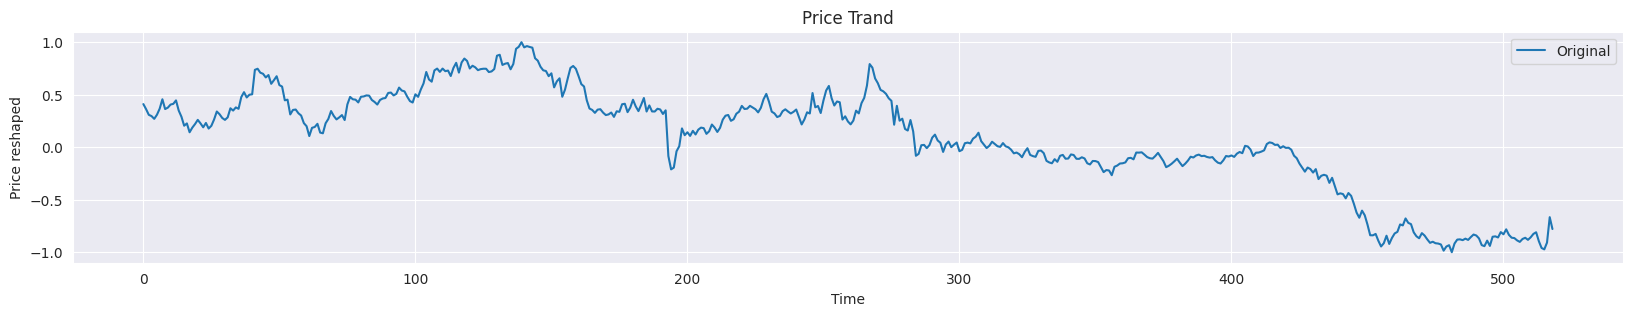

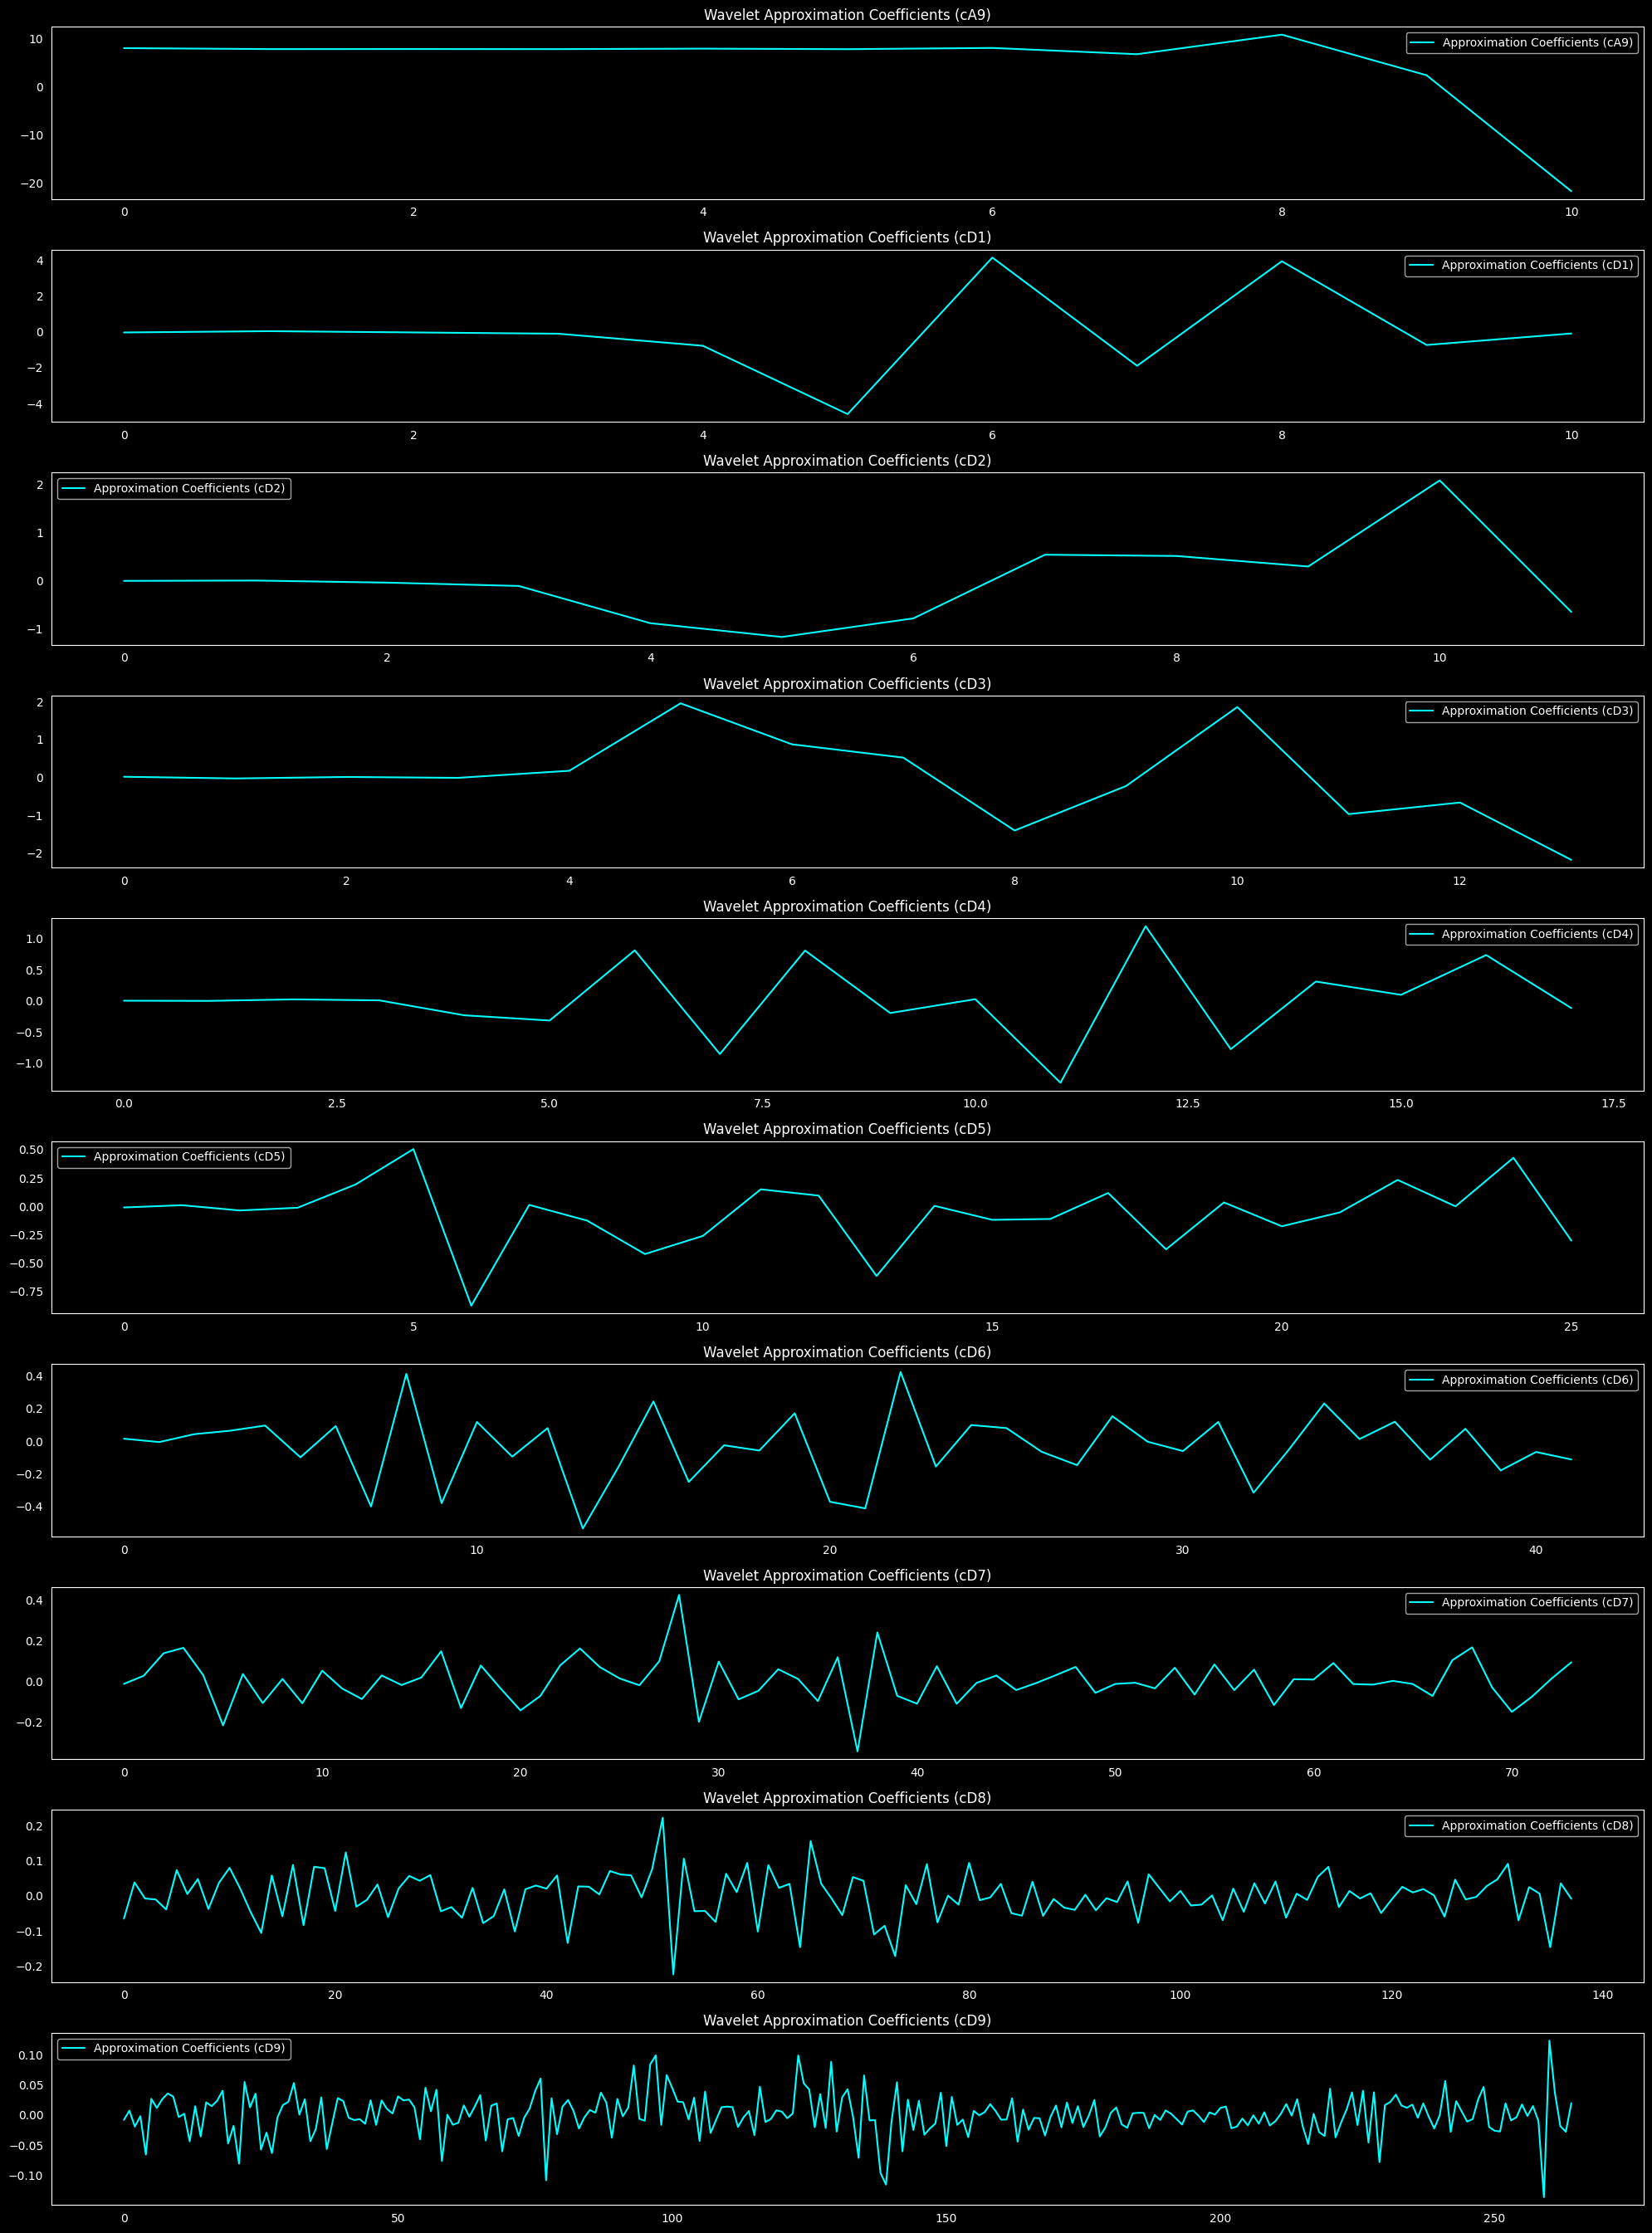

In [4]:

plt.figure(figsize=(20, 3))
plt.plot(prices, label='Original')


plt.title('Price Trand')
plt.xlabel('Time')
plt.ylabel('Price reshaped')
plt.legend()
plt.show()


# Plotting the wavelet coefficients
plt.style.use('dark_background')
plt.figure(figsize=(20, levels*3))
plt.subplot(levels+1, 1, 1)
plt.plot(coeffs[0], label=f'Approximation Coefficients (cA{levels})', color='cyan')
plt.title(f'Wavelet Approximation Coefficients (cA{levels})')
plt.legend()
plt.grid()

for lv in range(1,levels+1):
   plt.style.use('dark_background')
   plt.subplot(levels+1, 1, lv+1)
   plt.plot(coeffs[lv], label=f'Approximation Coefficients (cD{lv})', color='cyan')
   plt.title(f'Wavelet Approximation Coefficients (cD{lv})')
   plt.legend()
   plt.grid()


plt.tight_layout()
plt.show()

In [5]:

# Perform wavelet level filtering on time_series
def wavelet_level_filter(time_series, wavelet = 'db4', levels = 5, levels_to_filter=None):
    # Perform wavelet decomposition on the time series with N levels
    if levels_to_filter is None:
        levels_to_filter = [1, 2, 3, 4, 5]
    _series = time_series.reshape(-1, 1)
    coeffs = pywt.wavedec(_series.flatten(), wavelet, level=levels)
    # Reconstruct the signal without using the somelevels approximation coefficients
    filtered_coeffs = coeffs.copy()
    for i in levels_to_filter:
        #make them just zero
        filtered_coeffs[i] = np.zeros_like(filtered_coeffs[i])
  # Reconstruct the time series from the modified coefficients
    reconstructed = pywt.waverec(filtered_coeffs, wavelet)
    return reconstructed


In [6]:
highest_level = levels
# Extract the target variable and its corresponding index
target_variable = 'close_scaled'

time_index = df.index
time_series = df[target_variable].values
levels_to_filter = [3,4,5,6,7,8,9] # 5 left

/home/arsatyants/anaconda3/envs/wave/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


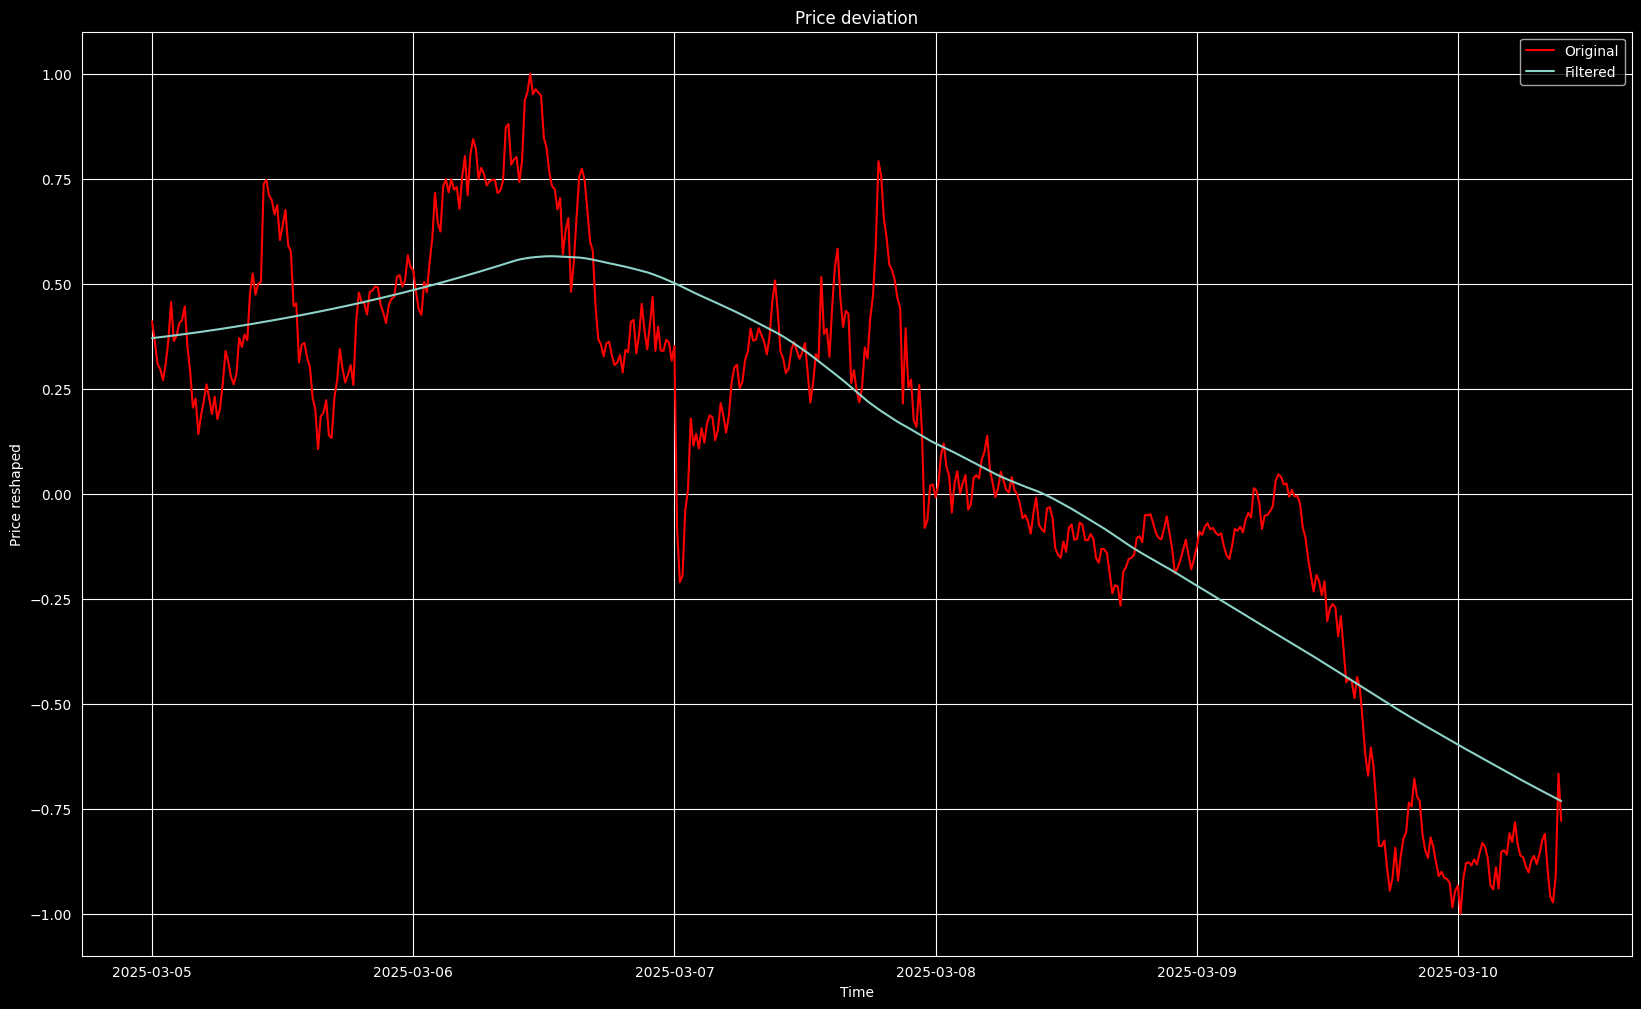

In [7]:
reconstructed_filtered = wavelet_level_filter(time_series, 'db4', highest_level, levels_to_filter)

# Create a DataFrame for the reconstructed time series with the original index
reconstructed_df = pd.DataFrame(reconstructed_filtered[:len(time_index)], index=time_index)
plt.style.use('dark_background')
plt.figure(figsize=(20, 12))
plt.plot(df[target_variable], label='Original', color='red')
plt.plot(reconstructed_df, label='Filtered')
plt.title('Price deviation')
plt.xlabel('Time')
plt.ylabel('Price reshaped')
plt.legend()
plt.show()


/home/arsatyants/anaconda3/envs/wave/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


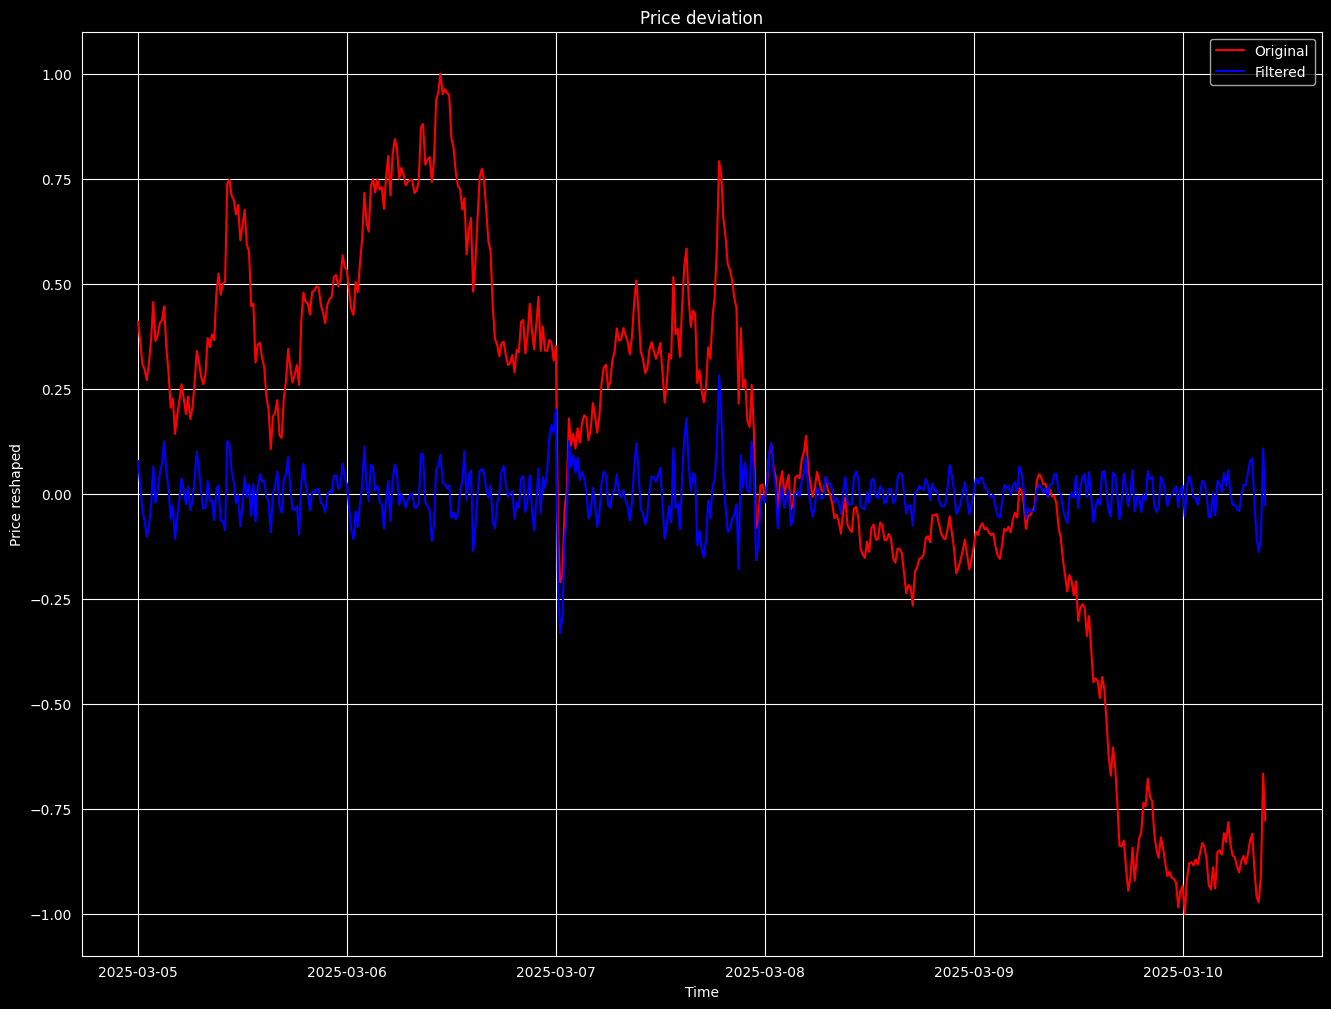

In [8]:

from turtle import color


highest_level = levels
# Extract the target variable and its corresponding index
target_variable = 'close_scaled'

time_index = df.index
time_series = df[target_variable].values
levels_to_filter = [0,1,2,3,4,5,6] 


reconstructed_filtered = wavelet_level_filter(time_series, 'db4', highest_level, levels_to_filter)

# Create a DataFrame for the reconstructed time series with the original index
reconstructed_df = pd.DataFrame(reconstructed_filtered[:len(time_index)], index=time_index)
plt.style.use('dark_background')
plt.figure(figsize=(16, 12))
plt.plot(df[target_variable], label='Original',color='red')
plt.plot(reconstructed_df, label='Filtered',color='blue')
plt.title('Price deviation')
plt.xlabel('Time')
plt.ylabel('Price reshaped')
plt.legend()
plt.show()

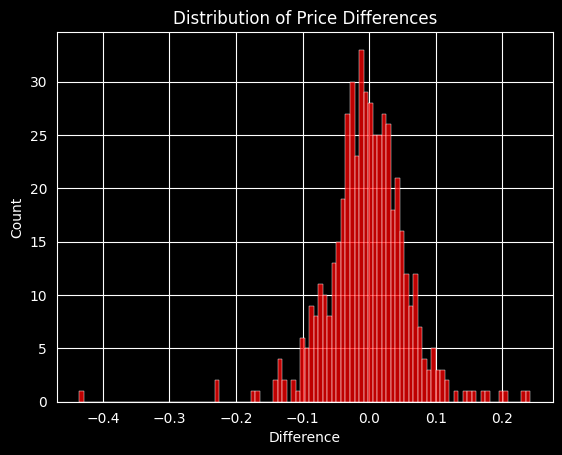

In [9]:
import seaborn as sns

# Calculate the difference between consecutive values
diff = np.diff(time_series)
sns.histplot(diff, bins=100, color='red')
plt.title('Distribution of Price Differences')
plt.xlabel('Difference')
plt.ylabel('Count')
plt.show()


In [10]:
def chart_stochastic_oscillator_and_price(ticker, df):

    df['ma50'] = df['close'].rolling(50).mean()
    df['ma200'] = df['close'].rolling(200).mean()

    plt.figure(figsize=[24, 20])
    plt.style.use('dark_background')
   
    fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [4, 4]})
    fig.suptitle(ticker)
    plt.subplots_adjust(hspace=0.03)
    ax[0].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax[0].grid(True)
    ax[0].axes.get_xaxis().set_visible(False)  # Remove X labels
    ax[0].set_ylabel(r'Price [\$]')
    ax[0].plot(df.index, df['close'], color='blue', linewidth=0.8)

    ax[1].plot(df.index, df['fast_k'], color='orange', linewidth=0.7)
    ax[1].plot(df.index, df['fast_d'], color='grey', linewidth=0.7)
    ax[1].plot(df.index, df['slow_d'], color='green', linewidth=0.7)
    ax[1].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax[1].grid(True)
    ax[1].set_ylabel(r'S.O.')
    ax[1].set_ylim(0, 100)
    ax[1].axhline(y=80, color='b', linestyle='-')
    ax[1].axhline(y=20, color='r', linestyle='-')
    plt.xticks(rotation=30, ha='right') 
    plt.show()



def stochastic_oscillator(df, n=14, m=3):
    """Calculate stochastic oscillator %K and %D."""    
    # Calculate the stochastic %K
    low_min  = df['low'].rolling(n).min()
    high_max = df['high'].rolling(n).max()
    df['fast_k'] = 100 * (df['close'] - low_min) / (high_max - low_min)
    df['fast_d'] = df['fast_k'].rolling(m).mean()
    df['slow_d'] = df['fast_d'].rolling(m).mean()
    return df

df = stochastic_oscillator(df)



<Figure size 2400x2000 with 0 Axes>

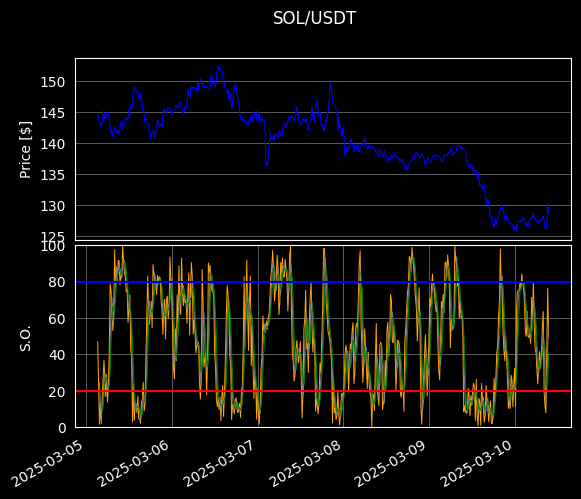

In [11]:
chart_stochastic_oscillator_and_price('SOL/USDT', df)

# Nadaraya-Watson

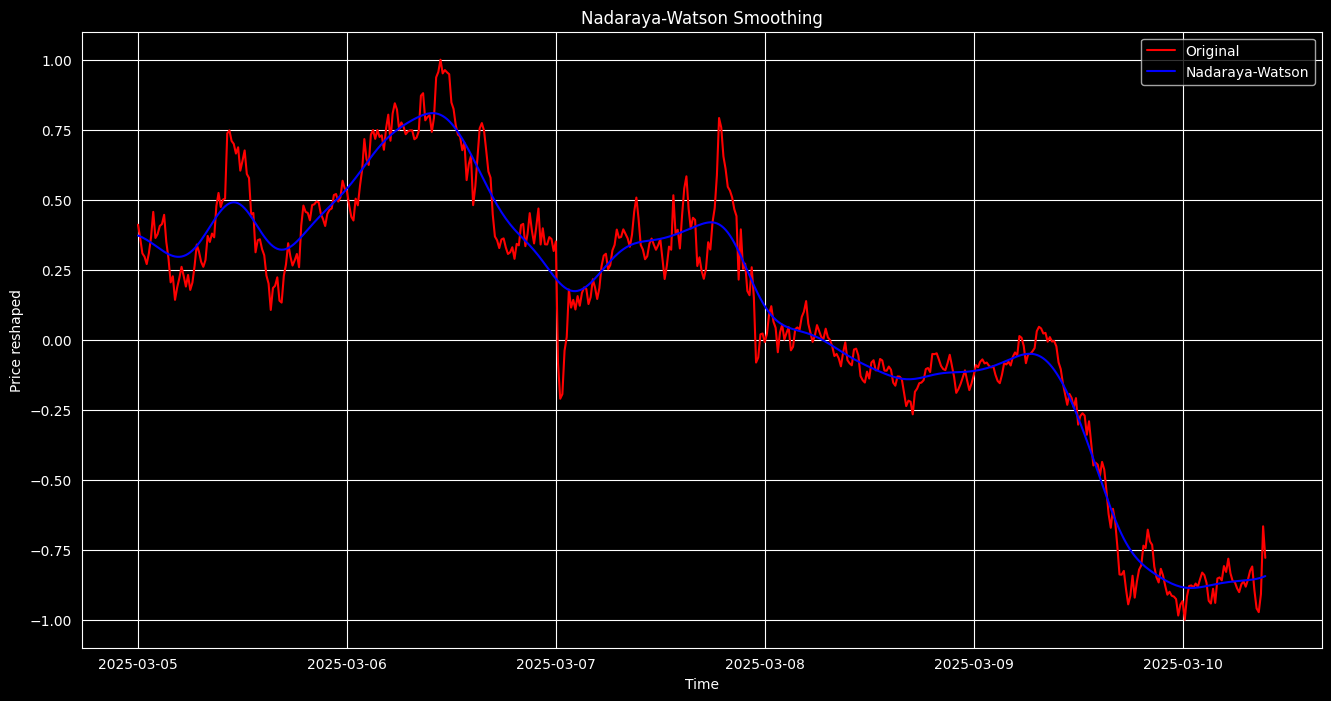

In [12]:
#%pip install statsmodels

from statsmodels.nonparametric.kernel_regression import KernelReg

# Define the Nadaraya-Watson estimator
def nadaraya_watson(x, y, bandwidth):
    model = KernelReg(endog=y, exog=x, var_type='c', bw=[bandwidth])
    y_pred, _ = model.fit(x)
    return y_pred

# Apply the Nadaraya-Watson estimator
x = np.arange(len(time_series))
y = time_series
bandwidth = 10
# You can adjust the bandwidth as needed
y_pred = nadaraya_watson(x, y, bandwidth)

# Plot the original and smoothed time series
plt.figure(figsize=(16, 8))
plt.plot(time_index, y, label='Original', color='red')
plt.plot(time_index, y_pred, label='Nadaraya-Watson', color='blue')
plt.title('Nadaraya-Watson Smoothing')
plt.xlabel('Time')
plt.ylabel('Price reshaped')
plt.legend()
plt.show()

In [13]:
data = df['close'].values


In [14]:

import math
h      = 8
mult   = 3
src    = data
k = 2
y = []
#..............#
up = []
dn = []
up_signal = []
dn_signal = []
up_temp = 0
dn_temp = 0
#.................#
upper_band = []
lower_band = []
upper_band_signal = []
lower_band_signal = []
#....................#
sum_e = 0
for i in range(len(data)):
    sum = 0
    sumw = 0   
    for j in range(len(data)):
        w = math.exp(-(math.pow(i-j,2)/(h*h*2)))
        sum += src[j]*w
        sumw += w
    y2 = sum/sumw
    sum_e += abs(src[i] - y2)
    y.insert(i,y2)
mae = sum_e/len(data)*mult
#print(mae)
import numpy as np
for i  in range(len(data)):
        y2 = y[i]
        y1 = y[i-1]
        
        if y[i]>y[i-1]:
            up.insert(i,y[i])
            if up_temp == 0:
                up_signal.insert(i,data[i])
            else:
                up_signal.insert(i,np.nan)
            up_temp = 1
        else:
            up_temp = 0
            up.insert(i,np.nan)
            up_signal.insert(i,np.nan)
            
        if y[i]<y[i-1]:
            dn.insert(i,y[i])
            if dn_temp == 0:
                dn_signal.insert(i,data[i])
            else:
                dn_signal.insert(i,np.nan)
            dn_temp = 1
        else:
            dn_temp = 0
            dn.insert(i,np.nan)
            dn_signal.insert(i,np.nan)
            
            
        upper_band.insert(i,y[i]+mae)
        lower_band.insert(i,y[i]-mae)
        if data[i]> upper_band[i]:
            upper_band_signal.insert(i,data[i])
        else:
            upper_band_signal.insert(i,np.nan)
            
        if data[i]<lower_band[i]:
            lower_band_signal.insert(i,data[i])
        else:
            lower_band_signal.insert(i,np.nan)       

In [15]:
import pandas as pd
Nadaraya_Watson = pd.DataFrame({
            "Buy": up,
            "Sell": dn,
            "BUY_Signal": up_signal,
            "Sell_Signal": dn_signal,
            "Uppar_Band": upper_band,
            "Lower_Band":lower_band,
            "Upper_Band_signal":upper_band_signal,
            "Lower_Band_Signal":lower_band_signal
        })
#Nadaraya_Watson

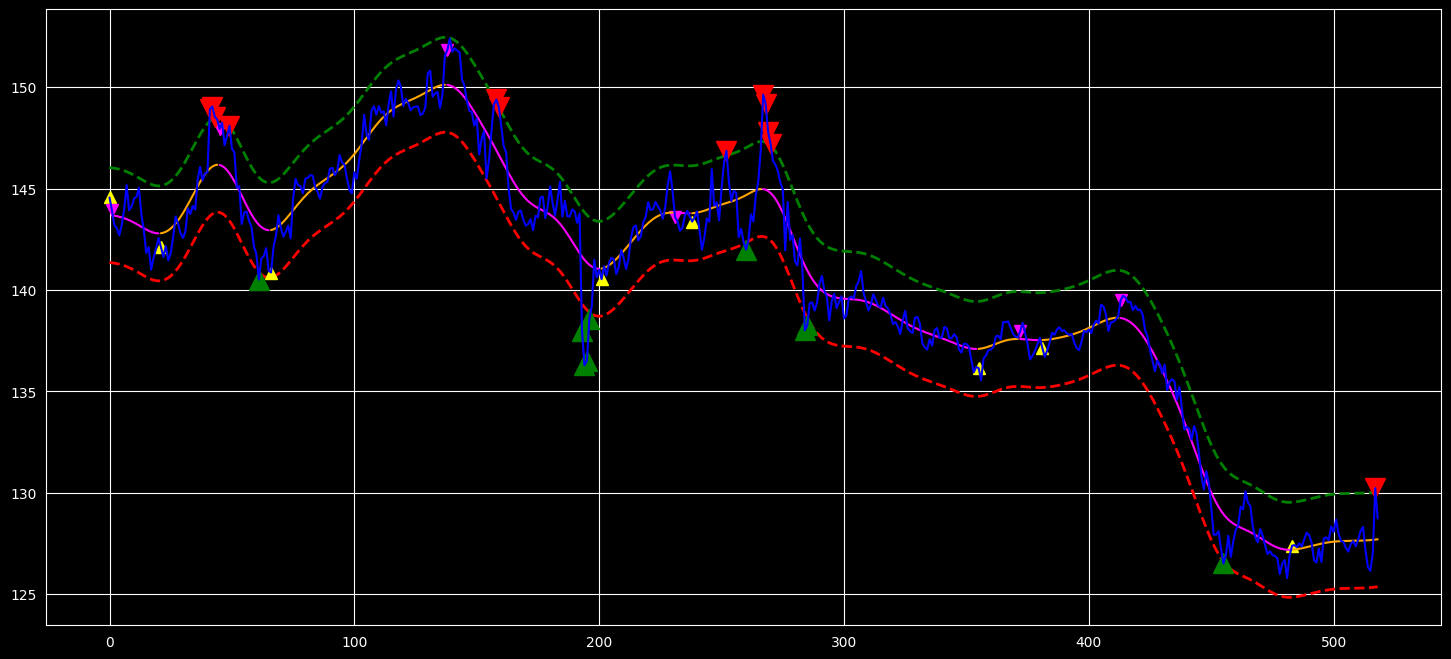

In [16]:
%matplotlib inline    
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))

plt.plot(np.array(upper_band), color= 'green', linestyle='--', linewidth=2) 
plt.plot(np.array(lower_band), color= 'red', linestyle='--', linewidth=2) 

plt.plot(np.array(up_signal), color= 'yellow', marker='^', linestyle='dashed', linewidth=1, markersize=8) 
plt.plot(np.array(dn_signal), color= 'magenta', marker='v', linestyle='dashed', linewidth=1, markersize=8) 

plt.plot(np.array(dn), color= 'magenta', label= 'Polynomial model') 
plt.plot(np.array(up), color= 'orange', label= 'Polynomial model')
plt.plot(np.array(upper_band_signal), color= 'red', marker='v', linestyle='dashed', linewidth=1, markersize=15) 
plt.plot(np.array(lower_band_signal), color= 'green', marker='^', linestyle='dashed', linewidth=1, markersize=15) 


plt.plot(np.array(data[:]), color= 'blue', label= 'Data')
plt.show()